*Load and preprocess corpus*

List of the caracters used

In [1]:
import spacy
import re
from pathlib import Path
import ftfy
import numpy as np
import sys
import glob
from PIL import Image
#!{sys.executable} -m pip install python-louvain
#!{sys.executable} -m pip install louvain
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m pip install ftfy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install Pillow



allnames_withliers=['Pison', 'Hiddekel', 'Adam', 'Eve', 'Cain', 'Enoch', 'Irad', 'Methusael', 'Lamech', 'Zillah', 'Seth', 'Enos', 'Methuselah', 'Noah', 'Canaan', 'Shem', 'Cush', 'Mizraim', 'Heth', 'Gether', 'Salah', 'Eber', 'Peleg', 'Jerah', 'Uzal', 'Diklah', 'Obal', 'Terah', 'Abram', 'Haran', 'Lot', 'Sarai', 'Shinab', 'Zoar', 'Dan', 'Sarah', 'Benammi', 'Nahor', 'Buz', 'Kemuel', 'Chesed', 'Jidlaph', 'Rebekah', 'Laban', 'Zimran', 'Medan', 'Jokshan', 'Sheba', 'Epher', 'Abidah', 'Isaac', 'Ishmael', 'Rachel', 'Bilhah', 'Levi', 'Jacob', 'Asher', 'Reuben', 'Zebulun', 'Dinah', 'Joseph', 'Deborah', 'Benjamin', 'Naphtali', 'Korah', 'Omar', 'Zepho', 'Zerah', 'Jaalam', 'Lotan', 'Shobal', 'Dishan', 'Samlah', 'Baalhanan', 'Mehetabel', 'Hirah', 'Onan', 'Pharez', 'Jachin', 'Shaul', 'Arodi', 'Malchiel', 'Belah', 'Jordan', 'Ephron', 'Machir', 'Abraham', 'Aaron', 'Jethro', 'Zipporah', 'Shimi', 'Elzaphan', 'Eleazar', 'Miriam', 'Hur', 'Joshua', 'Eliezer']
allnames=['Pison', 'Hiddekel', 'Adam', 'Eve', 'Cain', 'Enoch', 'Irad', 'Lamech', 'Zillah', 'Seth', 'Enos', 'Methuselah', 'Noah', 'Canaan', 'Shem', 'Cush', 'Heth', 'Gether', 'Salah', 'Peleg', 'Jerah', 'Uzal', 'Diklah', 'Obal', 'Terah', 'Abram', 'Sarai', 'Shinab', 'Zoar', 'Dan', 'Sarah', 'Benammi', 'Nahor', 'Buz', 'Kemuel', 'Chesed', 'Jidlaph', 'Rebekah', 'Laban', 'Zimran', 'Medan', 'Sheba', 'Epher', 'Abidah', 'Isaac', 'Rachel', 'Bilhah', 'Levi', 'Asher', 'Reuben', 'Zebulun', 'Dinah', 'Joseph', 'Benjamin', 'Naphtali', 'Korah', 'Omar', 'Zepho', 'Zerah', 'Jaalam', 'Lotan', 'Shobal', 'Dishan', 'Samlah', 'Baalhanan', 'Mehetabel', 'Hirah', 'Onan', 'Pharez', 'Jachin', 'Shaul', 'Arodi', 'Malchiel', 'Belah', 'Jordan', 'Machir', 'Aaron', 'Jethro', 'Zipporah', 'Shimi', 'Elzaphan', 'Miriam', 'Hur', 'Joshua', 'Eliezer']
lg_allnames = len(allnames)



In [2]:
def get_index(list_name):
    """Return the list of indices, in the global list of names, of the names in list_name
    """
    list_index=[]

    for i in list_name:
        for j in range(lg_allnames):
            if(i==allnames[j]):
                list_index.append(j)

    return list_index

In [3]:
import numpy as np
def update_matrix(names, matrix_occ, matrix_diag):
    """Based on a list of names, update the matrix of occurence and the diagonal matrix
    Param
    -----------
    names : [str] List of names
    matrix_occ : [[int]] matrix containing 1 if 2 caracters been mentionned in a same verset
    matrix_diag : [[int]] matrix diagonal containing the degree of each nodes (the number of contacts with others characters)
    """
    if names:
        list_index = get_index(names)

        for i in range(len(list_index)-1):
            for j in range(i+1,len(list_index)):
                # Verify if the two characters not been mentionned in a same verset before
                if(matrix_occ[list_index[i]][list_index[j]]==0):
                    # Adding the fact that these two characters has been mentionned
                    matrix_occ[list_index[j]][list_index[i]]=1
                    matrix_occ[list_index[i]][list_index[j]]=1
                    # Add another new connection for the 2 characters
                    matrix_diag[list_index[i]][list_index[i]]+=1
                    matrix_diag[list_index[j]][list_index[j]]+=1
        
    return matrix_occ, matrix_diag

"""name_test = set(('Aaron', 'Hur', 'Benjamin'))
matrix1, matrix2 = update_matrix(name_test,np.zeros((lg_allnames,lg_allnames)), np.zeros((lg_allnames,lg_allnames)))"""


"name_test = set(('Aaron', 'Hur', 'Benjamin'))\nmatrix1, matrix2 = update_matrix(name_test,np.zeros((lg_allnames,lg_allnames)), np.zeros((lg_allnames,lg_allnames)))"

In [4]:
np.set_printoptions(threshold=sys.maxsize)

def extract_names(path):
    #names_by_verset={}
    NER = spacy.load("en_core_web_sm")
    # Load the text document in a list of verset
    doc = Path(path, encoding='cp1252').read_text(encoding='cp1252').split('\n\n')

    matrix_occ = np.zeros((lg_allnames, lg_allnames))
    matrix_diag = np.zeros((lg_allnames,lg_allnames))

    for i in range(len(doc)):
        # Preprocess and clean each verset
        doc[i]= re.sub(' +', ' ', ftfy.fix_text(doc[i]))
        doc[i]= re.sub('\n', ' ', doc[i])
        doc[i]= re.sub('\'', ' ', doc[i])

        # Init the key i to get all names present in the verset ith
        names_by_verset = []
        text1= NER(doc[i])

        # Incorpore each name once in the dictionnary at the ith position
        for word in text1.ents:
            if(word.label_ == "PERSON"):
                if(word.text in allnames):
                    if(word.text not in names_by_verset):
                        names_by_verset.append(word.text)

        matrix_occ, matrix_diag =update_matrix(names_by_verset, matrix_occ, matrix_diag)
    return matrix_occ, matrix_diag

"""matrix_occ, matrix_diag = extract_names('bible12_n.txt')

a_file = open("matrix_occ.txt", "w")
for row in matrix_occ:
    np.savetxt(a_file, row)

a_file.close()

b_file = open("matrix_D.txt", "w")
for row in matrix_diag:
    np.savetxt(b_file, row)

b_file.close()"""




'matrix_occ, matrix_diag = extract_names(\'bible12_n.txt\')\n\na_file = open("matrix_occ.txt", "w")\nfor row in matrix_occ:\n    np.savetxt(a_file, row)\n\na_file.close()\n\nb_file = open("matrix_D.txt", "w")\nfor row in matrix_diag:\n    np.savetxt(b_file, row)\n\nb_file.close()'

In [5]:
matrix_occ = np.loadtxt("matrix_occ.txt").reshape(lg_allnames, lg_allnames)
matrix_diag = np.loadtxt("matrix_D.txt").reshape(lg_allnames, lg_allnames)

Plot the addition between the 2 matrix

/var/folders/gj/3zjx0x1d3x3bj6bfrlgym5fw0000gs/T/ipykernel_90621/3177483714.py:14: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(matrix)


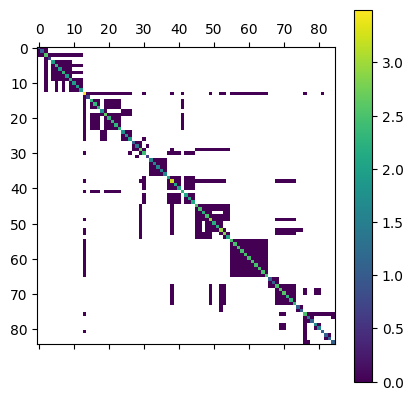

In [6]:
import matplotlib.pyplot as plt
def plot_matrix(matrix):


    for i in range (len(matrix)):
        for j in range (len(matrix)):

            if (i!=j):
                if (matrix[i][j]==0 ):
                    matrix[i][j] =1
                elif (matrix[i][j]==1 ):
                    matrix[i][j] =0

    matrix = np.log(matrix)
    plt.matshow(matrix)
    plt.colorbar()
    plt.show()

plot_matrix(matrix_diag-matrix_occ+1)

Graph with 85 nodes and 337 edges


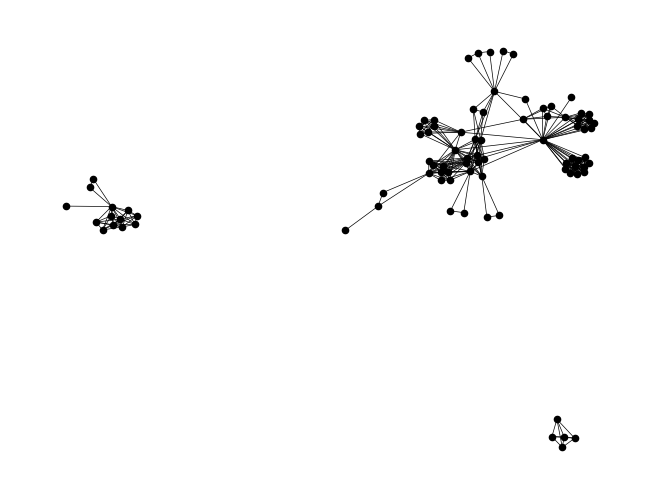

In [7]:
import networkx as nx
def create_graph(matrix):
    G = nx.Graph()


    G.add_nodes_from([i for i in range(lg_allnames)], weight = [matrix[i][i] for i in range(lg_allnames)])

    for j in range(lg_allnames-1):
        for k in range (j+1,lg_allnames,1):
            if(matrix_occ[j][k]!=0):
                G.add_edge(j,k)


    return G

graph_net = create_graph(matrix_diag+matrix_occ)
nx.draw(graph_net, nx.spring_layout(graph_net), node_color='black', node_size=20, width=0.5)
print(graph_net)


average degree = 7.929411764705883


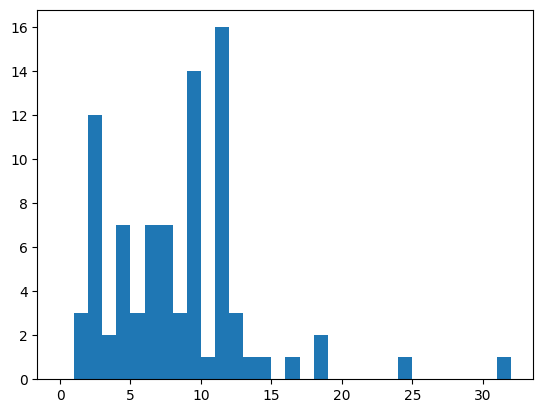

In [14]:
def display_histo(matrix):
    """Display a histo of the degree's frequencies
    """

    maximum = int(matrix.max())

    diagoV = [matrix[i][i] for i in range (len (matrix))]
    average = sum(diagoV) / len(diagoV)
    print("average degree = " + str (average))
    plt.hist(diagoV,bins = list(range(0,int(maximum)+1)))


    plt.show()

display_histo(matrix_diag)

In [9]:
"""!pip3 install python-louvain"""


'!pip3 install python-louvain'

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 4, 28: 4, 29: 2, 30: 6, 31: 4, 32: 5, 33: 5, 34: 5, 35: 5, 36: 5, 37: 6, 38: 2, 39: 6, 40: 6, 41: 3, 42: 6, 43: 6, 44: 6, 45: 2, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 2, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 83: 2, 84: 2}


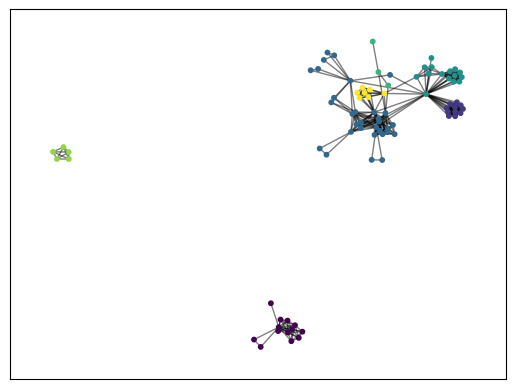

In [49]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

def louvain(G):

    partition = community_louvain.best_partition(G)
    print(partition)


    pos = nx.spring_layout(G, seed=41)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=10,cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

louvain(graph_net)

[0, 3]
[0, 3, 20]
[0, 3, 20, 62]
[0, 3, 20, 62, 72]


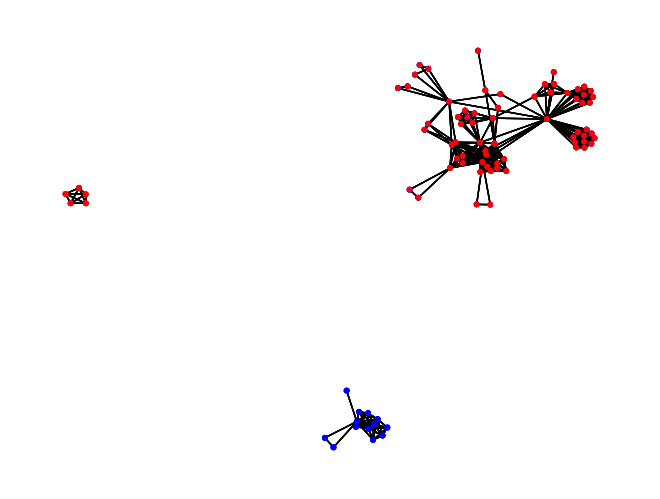

In [46]:
import random
from matplotlib import pyplot as plt, animation
import glob
import os

def cascade(G,starts):
    Visited=[]
    next=[]
    color_map=[]
    spreading_curve=[0]
    pos = nx.spring_layout(G, seed=41)
    def nextNode(G):
        target=[]
        for j in range (len(next)):
            neighbors = list(nx.neighbors(G,next[j]))
            for i in range(len(neighbors)):
                if neighbors[i] not in target and neighbors[i] not in Visited:
                    target.append(neighbors[i])
        
        next.clear()
        next.extend(target)
        Visited.extend(next)
    
    def ShowGraph(G,i):
        
        ##print(next)
        color_map.clear()
        for node in G:
            if node in Visited:
                color_map.append('red')
            else: 
                color_map.append('blue')  
                
        nx.draw(G,pos=pos,node_color=color_map,node_size=10)
        imageName = "images/"+str(i)
        plt.savefig(imageName)
        
        
    def truncate(path):
        files = glob.glob(path+'/*.*')
        for f in files:
            os.remove(f)
    
    Visited.extend(starts)
    next.extend(starts)
    
    i=1
    truncate("images")
    while (True):
        
        spreading_curve.append(len(Visited))
        print(spreading_curve)
        ShowGraph(G,i)
        i=i+1
        nextNode(G)
        
        
        if (len(next) == 0):
            break
        #input("Press Enter to continue...")
        
    return spreading_curve        
    
    
        
spreading_curve = cascade(graph_net,random.sample(range(0, nx.number_of_nodes(graph_net)), 3))
plt.show()

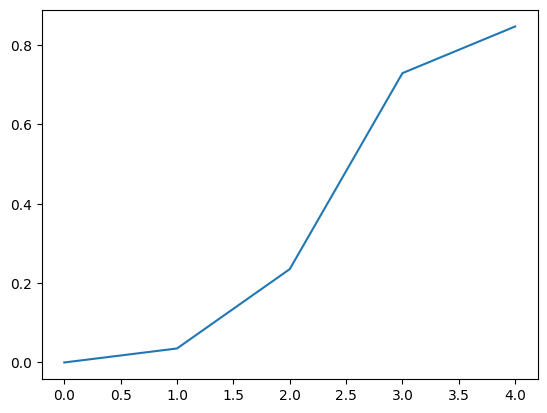

In [48]:
def plotSpreadingCurve(spreading_curve):
    for i in range (len(spreading_curve)):
        spreading_curve[i]=spreading_curve[i]/85
    plt.plot(spreading_curve)
    plt.show
plotSpreadingCurve(spreading_curve)

In [47]:
import glob
from PIL import Image

# filepaths
fp_in = "images/*.png"
fp_out = "gif.gif"


imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)


![my_awesome.gif](gif1.gif)




0

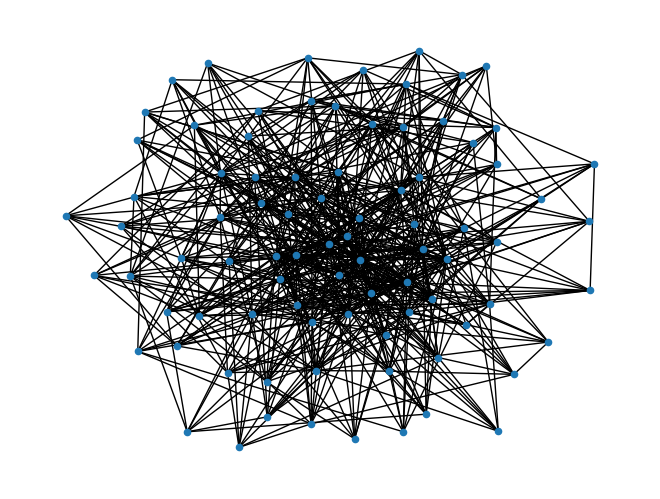

In [22]:
def Barabasi_Albert(G):
    BA = nx.barabasi_albert_graph(nx.number_of_nodes(G), 8)
    nx.draw(BA,node_size=20)
    return 0

Barabasi_Albert(graph_net)